<center><h1>Assignment 4</h1>
<h2> Support Vector Machine </h2>
<br>
<p>Apply the Scikit Learn SVM Classifier to the Iris dataset using all three categories and all four features at once.
<br>Run the SVM model (at least) four times using a different kernel each time. Compare and discuss the results for each of the kernels.</p></center>

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


In [57]:
# read Iris data set
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header = None)

In [58]:
# currently iris has columns names '0'-'4'. We want meaningful names,
# so we will change it.
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h3>Split data into training and testing sets</h3>

In [82]:
# features: everything except the 'species' column
X = iris.drop('species', axis = 1)

# what are we trying to predict?
y = iris['species']

#split data. We will use 30% of data to train the model and 70% to test it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state=20)

<h3> Scaling data</h3>
<p>According to the https://scikit-learn.org/ "it is highly recommended to scale your data" because Support Vector Machine algorithms are not scale invariant. Main purpose of scaling data before processing is to avoid attributes in greater numeric ranges. Iris data doesn't really have attributes in greater numeric ranges, so probably we could skip scaling. We did it for sake of practicing.</p>

In [83]:
# We scale the data in the range [-1,1]
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

<h3>Train a model</h3>
<p> We will check how using different kernels influences accuracy of the model. We will consider Radial Basis Function kernel, linear kernel, polynomial of degrees 2,3, and sigmoid kernel.</p>

In [93]:
models = (svm.SVC(kernel='rbf'),
          svm.SVC(kernel='sigmoid'),
          svm.SVC(kernel='poly', degree=2, gamma='auto'),
          svm.SVC(kernel='poly', degree=3, gamma='auto'),
          svm.SVC(kernel='linear'))

titles = ['rbf',
          'sigmoid',
          'poly (deg.2)',
          'poly (deg.3)',
          'linear']


<h3> Cross-validation </h3>
<p> In order to avoid overfitting, another part of the dataset can be held out as a “validation set”, which reduces number of samples which can be used for learning the model. That is why we can use k-fold cross-validation. This can be computationally expensive, but solves the problem of reducing samples number, which is important for a small data set like Iris.</p>

Kernel                                  CV accuracy score   Test accuracy score 

rbf                                       0.933333            0.966667
sigmoid                                   0.950000            0.955556
poly (deg.2)                              0.666667            0.588889
poly (deg.3)                              0.750000            0.611111
linear                                    0.933333            0.966667


([<matplotlib.axis.XTick at 0x1635d23f3c8>,
 <a list of 5 Text xticklabel objects>)

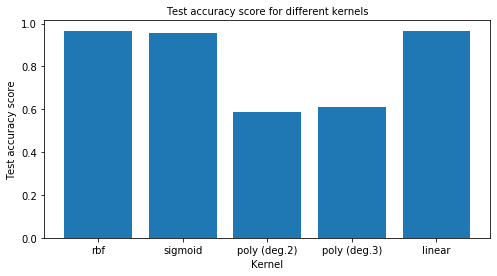

In [104]:
# text format 
bold_start = "\033[1m"
bold_end = "\033[0;0m"

print(bold_start + "{:40}{:20}{:20}".format('Kernel', 'CV accuracy score', 'Test accuracy score') + bold_end+ '\n')   
accuracy = []
for i, model in enumerate(models):
    cv_performance = cross_val_score(model, X_train, y_train,cv=10)
    test_performance = model.fit(X_train, y_train).score(X_test,y_test)
    accuracy.append(test_performance)
    print ("{:40}{:10f}{:20f}".format(titles[i], np.mean(cv_performance),test_performance))
    
#visualize
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
ax.set_xlabel('Kernel')
ax.set_ylabel('Test accuracy score')
ax.set_title("Test accuracy score for different kernels", fontsize ='medium')
y_pos = np.arange(len(titles))
ax.bar(y_pos,accuracy, label='train')
plt.xticks(y_pos, titles)


<p> We notice that the models worked out really good except for the polynomial kernels.<br><br>
Because the data set is pretty small we can use Gram matrix of all possible inner products of vectors set to find optimal kernel (this information was taken from Udemy Data Science course).</p>

<h3>Look for better parameters</h3>
We can search for the best combinations of kernels and parameters (like C and gamma) using grid_search.
During the search, the code tests different combinations of linear and RBF together with C and gamma parameters. C is important because it controls the cost of misclassification of training data. A large C value gives low bias (because we penalize the cost of misclassification a lot) and large variance, therefore it creates a larger-margin hyperplane.
Large Gamma leads to small variance and large bias. A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. 

In [111]:
from sklearn.model_selection import GridSearchCV

learning_algo = svm.SVC(kernel='linear', random_state=101)

search_space = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0, 0.1, 0.01, 0.001, 0.0001]},
                {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'gamma': [0, 0.1, 0.01, 0.001, 0.0001]},
                {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'gamma': [0, 0.1, 0.01, 0.001, 0.0001], 'degree':[1,2,3,4,5]}]

gridsearch = GridSearchCV(learning_algo, param_grid=search_space, refit=True, cv=10)
gridsearch.fit(X_train,y_train)
print ('Best parameter: '+ str(gridsearch.best_params_))

cv_performance = gridsearch.best_score_
test_performance = gridsearch.score(X_test, y_test)

print ('Cross-validation accuracy score: %0.3f,'
' test accuracy score: %0.3f'
% (cv_performance,test_performance))

Best parameter: {'C': 10, 'kernel': 'linear'}
Cross-validation accuracy score: 0.950, test accuracy score: 0.967


As a result of best kernel/parameters search we came to the conclusion that linear kernel works the best for this data. However, RBF demonstrates extremely close accuracy.

<h3> Can we improve poly kernel performance? </h3>
We can try to find parameters C, gamma, and degree for polynomial kernel such that they give better accuracy.

In [118]:
learning_algo = svm.SVC(kernel='linear', random_state=101)

search_space = [{'kernel': ['poly'], 'C': [1, 10, 100, 1000], 
                 'gamma': [0, 0.1, 0.01, 0.001, 0.0001], 
                 'degree':[2,3,4,5]}]

gridsearch = GridSearchCV(learning_algo, param_grid=search_space, refit=True, cv=10)
gridsearch.fit(X_train,y_train)
print ('Best parameter: '+ str(gridsearch.best_params_))

cv_performance = gridsearch.best_score_
test_performance = gridsearch.score(X_test, y_test)

print ('\n'+ bold_start+'Cross-validation accuracy score: %0.3f,'
' test accuracy score: %0.3f'
% (cv_performance,test_performance)+bold_end)

Best parameter: {'C': 1000, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}

Cross-validation accuracy score: 0.933, test accuracy score: 0.933


As a result we got 93.3% test accuracy when gamma is small and C is large. Large Value of parameter C => small margin. Larger C values will take more time to train.

<h2> Summary </h2><br><br>
We analyzed iris data using support vector machine and different kernels.The special capability of kernel functions is to
map the original feature space into a new feature space reconstructed to achieve better classification of results. It’s similar to the polynomial expansion principle, but the mathematics behind it require fewer computations, allowing the algorithm to map complex response functions in less time and with more precision ("Machine Learning for Dummies" by J.Nueller and L.Massaron).<br><br>
We chose to use Radial Basis Function, linear, polynomial of degrees 2 and 3, and sigmoid kernels. As a result, after scaling data, cross-validation, and fitting data we figured that two most effective kernels for this data set are linear and RBF (accuracy 96.7%). Sigmoid function also gave us a good result of 95.5%. However, polynomial functions resulted in a low accuracy of 58.8% fir degree 2, and 61.1% for degree 3.<br><br>
After we analyzed models with default parameters, we decided to find out if there are other parameters of C, gamma, and degree which can lead to a better performance. So, we used grid_search and checked combinations of kernels and C, gamma, and degree parameters. Parameter C=10 for linear kernel worked the best for Iris data giving accuracy of 96.7%. So, we were not able to improve already high accuracy.<br><br>
However, we tried to improve accuracy of the polynomial kernel models and we again implemented grid_search for only polynomial kernel. As a result we were able to significally improve accuracy from 61.1% to 93.3% for polynomial of degree 3. We were able to get this result by using C = 100 and gamma = 0.1. 
Large Value of parameter C => small margin. Larger C values will take more time to train.